##Interpreting interactions in linear models 

This notebook outlines the conditional interpretation of multiplicative interaction terms in linear models and demonstrates an implementation in Python using the results produced by the **`statsmodels`** module. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import seaborn as sns 

##Engineer a data generating process

This is a simple linear model with a multiplicative interaction. 

In [2]:
np.random.seed(123)
x1 = np.random.randn(1000)
x2 = np.random.randn(1000)
x3 = x1 * x2
X = sm.add_constant(np.vstack([x1, x2, x3]).T)
y = 1.6 - (0.3 * x1) - (0.8 * x2) + (1.4 * x3) + np.random.randn(1000) * 5

##Fit a linear model to the data

In [3]:
model = sm.OLS(y, X).fit() 
print model.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     39.40
Date:                Fri, 08 Jan 2016   Prob (F-statistic):           4.59e-24
Time:                        10:02:02   Log-Likelihood:                -3009.0
No. Observations:                1000   AIC:                             6026.
Df Residuals:                     996   BIC:                             6046.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.6461      0.156     10.579      0.0

##Interpretation

When we specify a multiplicative interaction, we cannot directly interpret the marginal effect of the interaction term (i.e., the estimate) from the results in the regression table. The reason is simply that the estimate is now a conditional estimate, meaning that the marginal effect outcome given a unit change in one of the terms constituting the interaction is directly conditional on the value taken by the other term constituting the interaction. To make this explicit, let's look at the specification of the model above.

&nbsp; 

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3\left(x_1x_2\right) + \epsilon$$

Now, if we want to see the marginal effect of the variable $x_1$ on $y$, we have to look at the conditional estimates. This follows directly from the partial derivative of the above with respect to $x_1$. 

&nbsp; 

$$\frac{\partial y}{\partial x_1} = \beta_1 + \beta_3x_2$$

As we can see, the marginal effect is directly conditional on the value of $x_2$. So, using the results above, the effect of a one-unit change in $x_1$ on $y$ is given by 

&nbsp; 

$$\frac{\partial y}{\partial x_1} = -0.46 + 1.40\left(x_2\right)$$

So we can see that this composite estimate will be increasing in the value of $x_2$, since the estimate on the interaction term is positive. As a side note, when the value $x_2$ is equal to zero, the marginal effect of $x_1$ on $y$ is simply the estimate on $x_1$ that we see in the regression results.

In general, the most transparent way to interpret these conditional estimates is to plot them across values of the conditioning variable. Examples are shown below. 

##Standard errors

Just as the coefficient estimates for an interaction term are conditional on the value of constitutive terms, so are the sampling distributions from which those estimates are drawn. In other words, the standard errors on the interaction are variable across values of the constitutive term and cannot be interpreted directly from the regression table. To be specific, for the composite marginal effect of $x_1$ on $Y$ shown above, the variance is defined by

&nbsp; 

$$\sigma^2_{\frac{\partial y}{\partial x_1}} = \text{Var}(\hat{\beta_1}) + \left[ x_2^2 \times \text{Var}(\hat{\beta_3}) \right] + \left[ 2x_2 \times \text{Cov}(\hat{\beta_1}\hat{\beta_3}) \right]$$

Again, we see explicitly that the variance of the estimate is directly conditional on $x_2$, and we can obtain the standard errors by taking the square root of the above. As with the estimates, the best way to see the uncertainty in the conditional estimates is to plot the confidence interval, as below. 

##Evaluating interactions in Python

The first step is to extract the variance-covariance matrix from the model fit.

In [4]:
cov = model.cov_HC0

Now set up a range of values for $x_2$ to evaluate the conditional marginal effect of $x_1$ and the corresponding standard error in that effect. 

In [5]:
x2_range = X[:,2].mean() - (2 * np.std(X[:,2])), X[:,2].mean() + (2 * np.std(X[:,2]))
x2_values = np.linspace(x2_range[0], x2_range[1])
x1_effect = model.params[1] + model.params[3] * x2_values
x1_effect_se = np.sqrt(cov[1, 1] + (x2_values**2 * cov[3, 3]) + (2 * x2_values * cov[1, 3]))

Plot the resulting conditional coefficients and confidence intervals over $x_2$. 

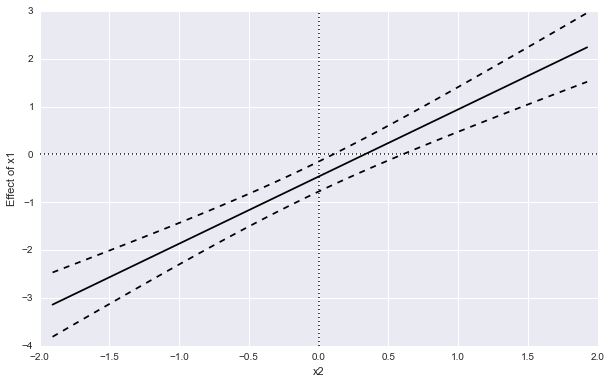

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(x2_values, x1_effect, 'k')
plt.plot(x2_values, x1_effect + (2 * x1_effect_se), 'k', linestyle='--')
plt.plot(x2_values, x1_effect - (2 * x1_effect_se), 'k', linestyle='--')
plt.axvline(x=0, linestyle=':', c='k', alpha=0.8)
plt.axhline(y=0, linestyle=':', c='k', alpha=0.8)
plt.xlabel('x2'); plt.ylabel('Effect of x1'); 

There are two things to note here. First, when $x_2 = 0$, the marginal effect of $x_1$ on $y$ is the coefficient estimate for $x_1$ that we see in the regression results table. Second, there is a range of values of $x_2$ for which the confidence interval for the marginal effect of $x_1$ contains 0, which tells us that we cannot reject the null hypothesis of no association *for these values of $x_2$*. In other words, in spite of the fact that our regression results indicate that the estimates on $x_1$ and the interaction term are statistically significant, there are some values of $x_2$ for which the marginal effect of $x_1$ is not statistically significant, a direct consequence of how conditional coefficients are estimated. 

We can repeat this process for the effect of $x_2$ conditional on the range of values for $x_1$. 

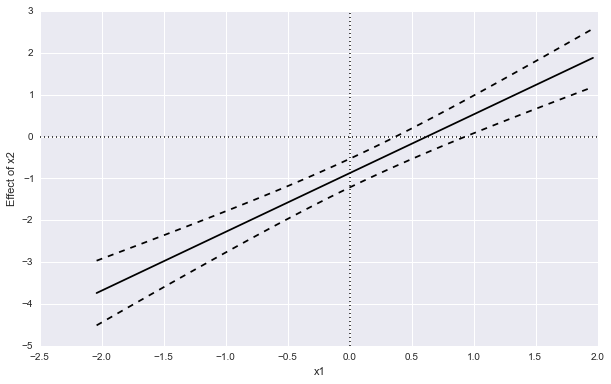

In [7]:
x1_range = X[:,1].mean() - (2 * np.std(X[:,1])), X[:,1].mean() + (2 * np.std(X[:,1]))
x1_values = np.linspace(x1_range[0], x1_range[1])
x2_effect = model.params[2] + model.params[3] * x1_values
x2_effect_se = np.sqrt(cov[2, 2] + (x1_values**2 * cov[3, 3]) + (2 * x1_values * cov[2, 3]))

plt.figure(figsize=(10, 6))
plt.plot(x1_values, x2_effect, 'k')
plt.plot(x1_values, x2_effect + (2 * x2_effect_se), 'k', linestyle='--')
plt.plot(x1_values, x2_effect - (2 * x2_effect_se), 'k', linestyle='--')
plt.axvline(x=0, linestyle=':', c='k', alpha=0.8)
plt.axhline(y=0, linestyle=':', c='k', alpha=0.8)
plt.xlabel('x1'); plt.ylabel('Effect of x2'); 